In [1]:
project_root_dir = "../../../"

import os
work_dir = os.path.abspath(project_root_dir)

import sys
sys.path.append(project_root_dir)

from pathlib import Path

import wandb
import re

import pandas as pd
from IPython.display import display, HTML
from functools import reduce
from itertools import cycle

import numpy as np

from src.utils import evaluation_helpers
from src.datamodules import IEGenericOutputDataset

import matplotlib.pyplot as plt

import seaborn as sns
from pprint import pprint

sns.set_theme(style="whitegrid")
sns.set_style("ticks")
sns.set_palette("deep")

params = {'mathtext.default': 'regular'}          
plt.rcParams.update(params)
size=15
params = {'legend.fontsize': 14,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': 25}
plt.rcParams.update(params)

In [2]:
# # Helper for getting the desired wandb run names and wandb paths

# def get_runs(prefix, lp, constraint, datamodule=None):
#     api = wandb.Api()
#     entity, project = "epfl-dlab", "SynthIE"  # set to your entity and project 
#     runs = api.runs(entity + "/" + project) 
#     run_name2wandb_path = {}
#     for run in runs:
#         if run.name.startswith(prefix) and f"constraint-{constraint}" in run.name and f"lp-{lp}" in run.name:
#             if datamodule is None or f"datamodule-{datamodule}" in run.name:
#                 run_name2wandb_path[run.name] = f"{entity}/{project}/{run.id}"

#     return run_name2wandb_path

# # prefixes = ["inf_fe_fully_synthetic_gcp_large_last", "inf_sc_fully_synthetic_gcp", "inf_full_fe_"]
# prefixes = ['inf_full_fe_']
# constraints = ["R-max-T5"]
# lps = ["0.8"]
# datamodules = ["rebel"]
# for prefix in prefixes:
#     print(f"Prefix: {prefix}")
#     run_name2wandb_path = {}
#     for constraint in constraints:
#         for lp in lps:
#             for datamodule in datamodules:
#                 run_name2wandb_path.update(get_runs(prefix, lp, constraint, datamodule))
#     pprint(run_name2wandb_path)
#     print()

In [3]:
run_name2wandb_path = {
# [Rebel] 
# GenIE-FE (base)
'inf_full_fe_rebel_ms_base_medium_lr_datamodule-rebel_world-genie_t5_tokenizeable_split-test_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/2h4ibqlg', ###
# SynthIE-FE (base)
'inf_full_fe_fully_synthetic_ms_base_medium_lr_datamodule-rebel_world-genie_t5_tokenizeable_split-test_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/2mlj6x38',  ###
# SynthIE-FE (large)
# 'inf_full_final_fe_fully_synthetic_gcp_large_last_datamodule-rebel_world-genie_t5_tokenizeable_split-test_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/cx55mnru',

# [SDG-Text]
# GenIE-FE (base)
'inf_full_final_fe_rebel_ms_base_medium_lr_datamodule-sdg_text_davinci_003_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/jr4d9aa3',
# SynthIE-FE (base)
'inf_full_final_fe_fully_synthetic_ms_base_medium_lr_datamodule-sdg_text_davinci_003_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/250e8fy8',
# SynthIE-FE (large)
# 'inf_full_final_fe_fully_synthetic_gcp_large_last_datamodule-sdg_text_davinci_003_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/o5empag8',

# [SDG-Code]
## GenIE-FE (base)
# 'inf_full_final_fe_rebel_ms_base_medium_lr_datamodule-sdg_code_davinci_002_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/zts0cqgk' # in progress ETC ~ 10pm 
## SynthIE-FE (base)
#'inf_full_final_fe_fully_synthetic_ms_base_medium_lr_datamodule-sdg_code_davinci_002_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/2fy0xmbw', 
## SynthIE-FE (large)
#'inf_full_final_fe_fully_synthetic_gcp_large_last_datamodule-sdg_code_davinci_002_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/3hvn11mw'
}


# Useful for the process_results launcher
# print(" ".join(list(run_name2wandb_path.values())))

In [11]:
# ~~~ Which experiments to consider? ~~~
# model_id_wandb_run_path_pairs = [("R", "martinj96/SynthIE/izr0vgpw"), ("R+S", "martinj96/SynthIE/2f857wrl"), ("R", "martinj96/SynthIE/3274th6j"), ("R+S", "martinj96/SynthIE/runs/22djwbxk")]
def get_model_id(run_name):
    _id = ""
    if "_fully_synthetic_" in run_name:
        _id += "SynthIE-T5"
    
    if "_rebel_" in run_name:
        _id += "GenIE-T5"

    if "_large_" in run_name:
        _id += "-large"
    else:
        _id += "-base"
    
    # if "_fe_" in run_name:
    #     _id += " (FE)"

    if "_sc_" in run_name:
        _id += "-SC"
    
    return _id

model_id_wandb_run_path_pairs = [(get_model_id(run_name), wandb_path) for run_name, wandb_path in run_name2wandb_path.items()][::-1]

metrics = ["num_target_triplets_centric_triplet_set_precision", "num_target_triplets_centric_triplet_set_recall", "num_target_triplets_centric_triplet_set_f1"]

n_bootstrap_samples = 50  # Set to None to present only the corpus level metric (without confidence intervals)
confidence_level = 0.95
confidence_interval_type = "percentile"
assert confidence_interval_type in ["percentile", "std"]

dataset_name2dataset_label = {"rebel": "REBEL", "sdg_code_davinci_002": "SynCode", "sdg_text_davinci_003": "SynText"}
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# ~~~ Plotting parameters ~~~
x_axis_label = "Number of target triplets"
metric_name2label = {"num_target_triplets_centric_triplet_set_precision": "Precision", "num_target_triplets_centric_triplet_set_recall": "Recall", "num_target_triplets_centric_triplet_set_f1": "F1"}
right_y_axis_label = "Portion of datatapoints"

figsize=(14, 7)
# 
# line_colors=["r", "GoldenRod", "violet", "yellow"]

line_styles = ["-", "--"]
line_colors = ["r", "GoldenRod"]
line_color = {"GenIE": "GoldenRod", "SynthIE": "r"}
dataset_label2ax_idx = {dataset_name2dataset_label['rebel']: 0, dataset_name2dataset_label['sdg_text_davinci_003']: 1}

capsize=3
marker_style="o"
marker_size=50
marker_linewidth=2.5
drop_top_frame=True
add_title=False
linewidth = 2
show_plot=True

horizontal = False
output_dir="plots"
# output_file_name="bucket-plot-num-target-triplets_models-genie-base--synthie-base_datasets-rebel--syntext_horizontal"
# output_file_name="bucket-plot-num-target-triplets_models-genie-base--synthie-base_datasets-rebel--syntext_vertical"
output_file_name=None
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~

##### Define Experiment ID

In [5]:
# ~~~ Optional ~~~~
def retrieve_constraint_module_id(hydra_config):
    cm_cfg = hydra_config['model']['constraint_module']

    if cm_cfg == None or cm_cfg == 'None':
        return "free"

    identifier2label = {'genie': 'R-max'}
    return identifier2label.get(cm_cfg['identifier'], cm_cfg['identifier'])

def retrieve_lenght_penalty(hydra_config):
    return hydra_config['model']['hparams_overrides']['inference']['hf_generation_params']['length_penalty']
# ~~~~~~~~~~~~~~~~~~

# The names of these functions should not change    
def get_exp_id(model_id, hydra_config):
    return f"{model_id} -- ({retrieve_constraint_module_id(hydra_config)}) lp_{retrieve_lenght_penalty(hydra_config)} -- {dataset_name2dataset_label[retrieve_dataset_name(hydra_config)]}"

def retrieve_dataset_name(hydra_config):
    return hydra_config['datamodule']['name']

results_df_field2getter = {"LP": retrieve_lenght_penalty, "Constraint": retrieve_constraint_module_id}

## Main Part

In [6]:
wandb_configs = {}
hydra_configs = {}
abs_exp_dirs = {}

output_datasets = {}
results = {}

exp_id2wandb_run_path = {}
exp_id2model_id = {}

for model_id, wandb_run_path in model_id_wandb_run_path_pairs:
    api = wandb.Api()
    run = api.run(wandb_run_path)
    wandb_config, hydra_config, abs_exp_dir = evaluation_helpers.prepare_data_for_experiment(wandb_run_path, work_dir, print)
    exp_id = get_exp_id(model_id, hydra_config)
    exp_id2wandb_run_path[exp_id] = wandb_run_path
    exp_id2model_id[exp_id] = model_id

    wandb_configs[exp_id], hydra_configs[exp_id], abs_exp_dirs[exp_id] = wandb_config, hydra_config, abs_exp_dir

    linearization_class_id = hydra_configs[exp_id]['datamodule'].get("linearization_class_id")
    data_dir = os.path.join(abs_exp_dirs[exp_id], "predictions")
    output_datasets[exp_id] = IEGenericOutputDataset(data_dir=data_dir, seed=123, linearization_class_id=linearization_class_id)

    # Load existing results data
    results[exp_id] = evaluation_helpers.Results(abs_exp_dirs[exp_id])

exp_ids = list(results.keys())

Experiment directory already exists: /Users/josifosk/Documents/PhD/SynthIE_main/logs/inference/runs/inf_full_final_fe_fully_synthetic_ms_base_medium_lr_datamodule-sdg_text_davinci_003_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8/2023-02-07_17-46-11
Loading the existing results
Experiment directory already exists: /Users/josifosk/Documents/PhD/SynthIE_main/logs/inference/runs/inf_full_final_fe_rebel_ms_base_medium_lr_datamodule-sdg_text_davinci_003_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8/2023-02-08_00-28-20
Loading the existing results
Experiment directory already exists: /Users/josifosk/Documents/PhD/SynthIE_main/logs/inference/runs/inf_full_fe_fully_synthetic_ms_base_medium_lr_datamodule-rebel_world-genie_t5_tokenizeable_split-test_constraint-R-max-T5_lp-0.8/2023-02-02_22-09-02
Loading the existing results
Experiment directory already exists: /Users/josifosk/Documents/PhD/SynthIE_main/logs/inference/runs/inf_full_fe_rebel_

In [14]:
def get_bucket_plot_data(results_obj, metric_name, left_y_label):
    # ~~~ Get the data ~~~
    if n_bootstrap_samples is None:
        scores_dict = results_obj.get_score(metric_name, per_bucket=True)
    else:
        if confidence_interval_type == "percentile":
            scores_dict = results_obj.get_percentile_based_ci(metric_name, 
                                                               confidence_level=confidence_level,
                                                               n_bootstrap_samples=n_bootstrap_samples,
                                                               per_bucket=True)
        elif confidence_interval_type == "std":
            scores_dict = results_obj.get_std_based_ci(metric_name, 
                                                       n_bootstrap_samples=n_bootstrap_samples, 
                                                       per_bucket=True)
        else:
            raise ValueError(f"Unknown confidence interval type: {confidence_interval_type}")
    scores_dict = {int(k): v for k, v in scores_dict.items()}

    metadata = results_obj.get_metadata(metric_id=metric_name)

    # ~~~~ Concerning the X axis ~~~~
    bucket_indices = sorted(list(scores_dict.keys()))
    bucket_idx2label = metadata["bucket_idx2label"]
    bucket_idx2label = {int(k): v for k, v in bucket_idx2label.items()}
    bucket_labels = [bucket_idx2label[bucket_idx] for bucket_idx in bucket_indices]

    # ~~~~ Concerning the Y axis ~~~~

    # Scores
    if n_bootstrap_samples is None:
        scores = [scores_dict[bucket_index] for bucket_index in bucket_indices]
        scores_err = None
    else:
        scores = []
        scores_err = []
        for bucket_index in bucket_indices:
            lower, mean, upper = scores_dict[bucket_index]
            scores.append(mean)
            scores_err.append((mean-lower, upper-mean)) 
        scores_err = np.array(scores_err).T

    # Distribution of number of target triplets
    bucket_idx2dp_indices = metadata['bucket_idx2dp_indices']
    bucket_idx2num_dps = {int(k): len(v) for k, v in bucket_idx2dp_indices.items()}
    freqs = [bucket_idx2num_dps[bucket_index] for bucket_index in bucket_indices]

    data_obj = {
        "x": bucket_labels,
        "left_y": scores,
        "left_y_err": scores_err,
        "left_y_label": left_y_label,
        "right_y": freqs,
    }

    return data_obj


def get_bucket_plot_bar_version(
        xs,
        x_axis_label,

        left_ys,
        left_y_errs,
        left_y_labels,
        left_y_axis_label,
        left_y_lim,

        right_ys,
        right_y_label,
        right_y_axis_label,
        right_y_lim,
        right_y_hatch=None,
        right_y_alpha=1,

        figsize=figsize,
        linestyle="-",
        line_colors=line_color,
        capsize=capsize,
        marker_style=marker_style,
        marker_size=marker_size,
        marker_linewidth=marker_linewidth,
        drop_top_frame=drop_top_frame,
        show_plot=show_plot,
        linewidth=linewidth,

        output_dir=output_dir,
        output_file_name=output_file_name
):
    if horizontal:
        n_rows = 1
        n_cols = len(dataset_label2ax_idx)
        figsize = (6*n_cols + 1, 4)
        ax2_pos = (0.68, 1.25)
    else:
        n_rows = len(dataset_label2ax_idx)
        n_cols = 1
        figsize = (6, 2.5*n_rows + 1)
        ax2_pos = (0.59, 1.25)
    fig, axs = plt.subplots(figsize=figsize, nrows=n_rows, ncols=n_cols, sharex=False, sharey=True)

    # ~~~ Left Plot ~~~
    for ax in axs:
        plt.setp(ax.patches, linewidth=0)
        
        if x_axis_label:
            if horizontal:
                ax.set_xlabel(x_axis_label)
            else:
                axs[-1].set_xlabel(x_axis_label)

        if left_y_lim:
            ax.set_ylim(*left_y_lim)
    
        if left_y_axis_label:
            if horizontal:
                axs[0].set_ylabel(left_y_axis_label)
            else:
                ax.set_ylabel(left_y_axis_label)
    
    for x, left_y, left_y_label, left_y_err in zip(xs, left_ys, left_y_labels, left_y_errs):
        color = None

        for key in line_color:
            if key in left_y_label:
                color = line_color[key]
                break
        if color is None:
            raise ValueError("Could not find color for {0}".format(left_y_label))

        dataset_label = left_y_label.split('--')[-1].strip()
        ax = axs[dataset_label2ax_idx[dataset_label]]

        left_y_label = f"{left_y_label.split('--')[0].strip().split('-')[0]}$_{{{'-'.join(left_y_label.split('--')[0].strip().split('-')[1:])}}}$"

        sns.lineplot(x=x, y=left_y, ax=ax, color=color, label=left_y_label, linestyle=linestyle, linewidth=linewidth)

        if left_y_err is not None:
            ax.errorbar(x=x, y=left_y, yerr=left_y_err, fmt="none", color="black", capsize=capsize, zorder=10000)

        if marker_size != 0:
            sns.scatterplot(
                ax=ax,
                x=x,
                y=left_y,
                marker=marker_style,
                color=color,
                linewidth=marker_linewidth,
                s=marker_size,
                edgecolor="none",
            )

    for dataset_label, ax_idx in dataset_label2ax_idx.items():
        ax = axs[ax_idx]

        if add_title:
            ax.set_title(dataset_label)

        for x, left_y, left_y_label, left_y_err, right_y in zip(xs, left_ys, left_y_labels, left_y_errs, right_ys):
            curr_data_label = left_y_label.split('--')[-1].strip()
            if dataset_label != curr_data_label:
                continue

            # ~~~ Right Plot ~~~
            ax2 = ax.twinx()
            plt.setp(ax2.patches, linewidth=0)

            sns.barplot(
                ax=ax2,
                x=x,
                y=np.array(right_y) / sum(right_y),
                palette=["#004d99"] * len(x),
                label=right_y_label,
                hatch=right_y_hatch,
                edgecolor="black",
                zorder=0,
                alpha=right_y_alpha,
            )

            if right_y_lim:
                ax2.set_ylim(*right_y_lim)

            ax.set_zorder(ax2.get_zorder() + 1)
            ax.set_frame_on(False)

            # ~~~~ General ~~~~
            if drop_top_frame:
                ax.spines["top"].set_visible(False)
                ax2.spines["top"].set_visible(False)

            ax.legend(loc="upper right", bbox_to_anchor=(1, 1.25), bbox_transform=ax.transAxes, frameon=False, ncol=1, labelspacing=0.2) #columnspacing=0.8)
            ax2.legend(loc="upper right", bbox_to_anchor=ax2_pos, bbox_transform=ax2.transAxes, frameon=False)
            break
    
        if horizontal:
            if ax_idx != len(dataset_label2ax_idx) - 1:
                ax.get_legend().remove()
                ax2.get_legend().remove()
            if right_y_axis_label and ax_idx == len(dataset_label2ax_idx) - 1:
                ax2.set_ylabel(right_y_axis_label)
        else:
            if right_y_axis_label:
                ax2.set_ylabel(right_y_axis_label)
            if ax_idx != 0:
                ax.get_legend().remove()
                ax2.get_legend().remove()

    plt.tight_layout(rect=(0, 0, 1, 0.98))

    if show_plot:
        plt.show()

    if output_file_name is not None:
        Path(output_dir).mkdir(parents=True, exist_ok=True)

        path_to_pdf_output_file = os.path.join(output_dir, f"{output_file_name}_{left_y_axis_label.lower()}.pdf")
        fig.savefig(path_to_pdf_output_file, dpi=300)

        path_to_png_output_file = os.path.join(output_dir, f"{output_file_name}_{left_y_axis_label.lower()}.png")
        fig.savefig(path_to_png_output_file, dpi=300)

    return fig, axs

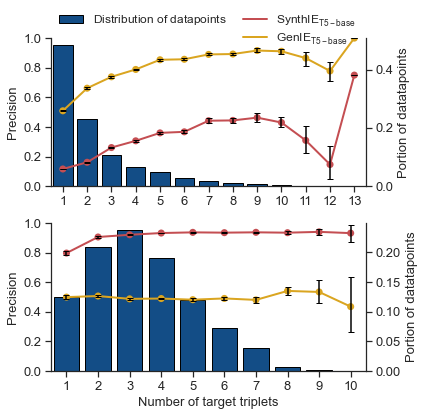

bucket-plot-num-target-triplets_models-genie-base--synthie-base_datasets-rebel--syntext_vertical


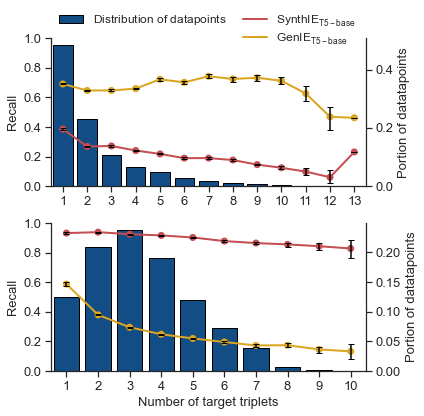

bucket-plot-num-target-triplets_models-genie-base--synthie-base_datasets-rebel--syntext_vertical


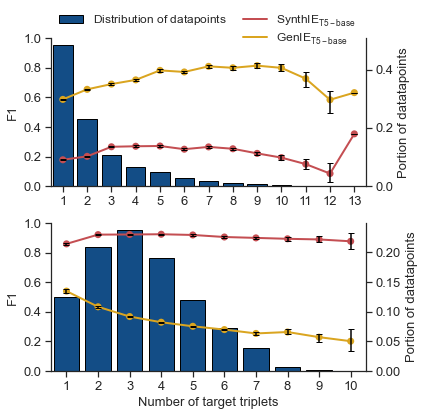

bucket-plot-num-target-triplets_models-genie-base--synthie-base_datasets-rebel--syntext_vertical


In [15]:
size=13
params = {'legend.fontsize': 12,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': 25}
plt.rcParams.update(params)

def get_plot_for_metric(metric_name):
    data_objs = []

    for exp_id in exp_id2wandb_run_path.keys():
        curr_results = results[exp_id]
        data_objs.append(get_bucket_plot_data(curr_results, metric_name, exp_id))

    plot_data = {
        "output_file_name": output_file_name,
        'linewidth': linewidth,
        "xs": [data_obj["x"] for data_obj in data_objs],
        "x_axis_label": x_axis_label,

        "left_ys": [data_obj["left_y"] for data_obj in data_objs],
        "left_y_errs": [data_obj["left_y_err"] for data_obj in data_objs],
        "left_y_labels": [data_obj["left_y_label"] for data_obj in data_objs],
        "left_y_axis_label": metric_name2label[metric_name],
        "left_y_lim": (0, 1),

        "right_ys": [data_obj["right_y"] for data_obj in data_objs],
        "right_y_label": r"$Distribution~of~datapoints$",
        "right_y_axis_label": right_y_axis_label,
        "right_y_lim": (None, None)
    }

    fig, axs = get_bucket_plot_bar_version(**plot_data)


for metric_name in metrics:
    get_plot_for_metric(metric_name)